In [2]:
%matplotlib inline
from matplotlib.pyplot import  imshow
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import *
from tensorlayer.prepro import *
from tensorlayer.cost import *
import numpy as np
import scipy
import nltk
import warnings
warnings.filterwarnings("ignore")

from model import *
import model

from utils import *

### load .npz file

In [3]:
save_dir='./checkpoint/'
print(os.listdir(save_dir))
ni = int(np.ceil(np.sqrt(batch_size)))

['net_cnn.npz', 'net_rnn.npz', 'net_g.npz', 'net_d.npz', 'net_cnn.npz100.npz', 'net_rnn.npz100.npz', 'net_g.npz100.npz', 'net_d.npz100.npz', 'net_encoder.npz']


In [4]:
print("Loading data from pickle ...")
import pickle
with open("./Data/_vocab.pickle", 'rb') as f:
    vocab = pickle.load(f)
with open("./Data/_image_train.pickle", 'rb') as f:
    _, images_train = pickle.load(f)
with open("./Data/_image_test.pickle", 'rb') as f:
    _, images_test = pickle.load(f)
with open("./Data/_n.pickle", 'rb') as f:
    n_captions_train, n_captions_test, n_captions_per_image, n_images_train, n_images_test = pickle.load(f)
with open("./Data/_caption.pickle", 'rb') as f:
    captions_ids_train, captions_ids_test = pickle.load(f)
# images_train_256 = np.array(images_train_256)
# images_test_256 = np.array(images_test_256)
images_train = np.array(images_train)
images_test = np.array(images_test)


Loading data from pickle ...


### placeholder

In [5]:
t_real_caption = tf.placeholder(dtype=tf.int64, shape=[batch_size, None], name='real_caption_input')
t_z = tf.placeholder(tf.float32, [batch_size, z_dim], name='z_noise')

### load pre-trained model

In [6]:
net_rnn = rnn_embed(t_real_caption, is_train=True, reuse=False)
generator_txt2img = model.generator_txt2img_resnet
 ## testing inference for txt2img
net_g, _ = generator_txt2img(t_z,
                    net_rnn.outputs,
                    is_train=True, reuse=False, batch_size=batch_size)

  [TL] EmbeddingInputlayer rnnftxt/rnn/wordembed: (8000, 256)
  [TL] DynamicRNNLayer rnnftxt/rnn/dynamic: n_hidden:128, in_dim:3 in_shape:(64, ?, 256) cell_fn:BasicLSTMCell dropout:1.0 n_layer:1
       batch_size (concurrent processes): 64
  [TL] InputLayer  generator/g_inputz: (64, 512)
  [TL] InputLayer  generator/g_input_txt: (64, 128)
  [TL] DenseLayer  generator/g_reduce_text/dense: 128 <lambda>
  [TL] ConcatLayer generator/g_concat_z_txt: 640
  [TL] DenseLayer  generator/g_h0/dense: 16384 identity
  [TL] BatchNormLayer generator/g_h0/batch_norm: decay:0.900000 epsilon:0.000010 act:identity is_train:True
  [TL] ReshapeLayer generator/g_h0/reshape: (64, 4, 4, 1024)
  [TL] Conv2dLayer generator/g_h1_res/conv2d: shape:[1, 1, 1024, 256] strides:[1, 1, 1, 1] pad:VALID act:identity
  [TL] BatchNormLayer generator/g_h1_res/batch_norm: decay:0.900000 epsilon:0.000010 act:relu is_train:True
  [TL] Conv2dLayer generator/g_h1_res/conv2d2: shape:[3, 3, 256, 256] strides:[1, 1, 1, 1] pad:SAME 

In [8]:
# load the latest checkpoints
sess=tf.Session()
net_rnn_name = os.path.join(save_dir, 'net_rnn.npz100.npz')
#net_cnn_name = os.path.join(save_dir, 'net_cnn.npz100.npz')
net_g_name = os.path.join(save_dir, 'net_g.npz100.npz')
#net_d_name = os.path.join(save_dir, 'net_d.npz100.npz')

load_and_assign_npz(sess=sess, name=net_rnn_name, model=net_rnn)
#load_and_assign_npz(sess=sess, name=net_cnn_name, model=net_cnn)
load_and_assign_npz(sess=sess, name=net_g_name, model=net_g)
#load_and_assign_npz(sess=sess, name=net_d_name, model=net_d)

[*] Loading ./checkpoint/net_rnn.npz100.npz model SUCCESS!
[*] Loading ./checkpoint/net_g.npz100.npz model SUCCESS!


### sample sentence

In [9]:
## seed for generation, z and sentence ids
import nltk
sample_size = batch_size
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, z_dim)).astype(np.float32)
# sample_seed = np.random.uniform(low=-1, high=1, size=(sample_size, z_dim)).astype(np.float32)]
n = int(sample_size / ni)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * n + \
                      ["this flower has petals that are yellow, white and purple and has dark lines"] * n + \
                      ["the petals on this flower are white with a yellow center"] * n + \
                      ["this flower has a lot of small round pink petals."] * n + \
                      ["this flower is orange in color, and has petals that are ruffled and rounded."] * n + \
                      ["the flower has yellow petals and the center of it is brown."] * n + \
                      ["this flower has petals that are blue and white."] * n +\
                      ["these white flowers have petals that start off white in color and end in a white towards the tips."] * n

# sample_sentence = captions_ids_test[0:sample_size]
for i, sentence in enumerate(sample_sentence):
    print("seed: %s" % sentence)
    sentence = preprocess_caption(sentence)
    sample_sentence[i] = [vocab.word_to_id(word) for word in nltk.tokenize.word_tokenize(sentence)] + [vocab.end_id]    # add END_ID
    # sample_sentence[i] = [vocab.word_to_id(word) for word in sentence]
    # print(sample_sentence[i])
sample_sentence = tl.prepro.pad_sequences(sample_sentence, padding='post')

seed: the flower shown has yellow anther red pistil and bright red petals.
seed: the flower shown has yellow anther red pistil and bright red petals.
seed: the flower shown has yellow anther red pistil and bright red petals.
seed: the flower shown has yellow anther red pistil and bright red petals.
seed: the flower shown has yellow anther red pistil and bright red petals.
seed: the flower shown has yellow anther red pistil and bright red petals.
seed: the flower shown has yellow anther red pistil and bright red petals.
seed: the flower shown has yellow anther red pistil and bright red petals.
seed: this flower has petals that are yellow, white and purple and has dark lines
seed: this flower has petals that are yellow, white and purple and has dark lines
seed: this flower has petals that are yellow, white and purple and has dark lines
seed: this flower has petals that are yellow, white and purple and has dark lines
seed: this flower has petals that are yellow, white and purple and has d

In [10]:
img_gen, rnn_out = sess.run([net_g.outputs, net_rnn.outputs], feed_dict={
                                        t_real_caption : sample_sentence,
                                        t_z : sample_seed})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


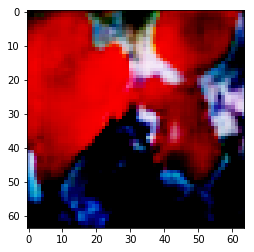

In [22]:
imshow(img_gen[1])